### Charlie Buhanan
### 4/23/2024
### Project 3: Sentiment Analysis of Reviews
#### How good are the tacos in Salt Lake City?

#### How good are the tacos in salt lake city?
#### Using a combination of different sentiment analysis methods, we can analyze the reviews of tacos in the salt lake city area.

#### Setup & Imports

In [17]:
import requests
import yelpkeys  # file where client_id and api_key is defined with user's private app information
from textblob import TextBlob
import nltk
from textblob.sentiments import NaiveBayesAnalyzer
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
APIKEY = yelpkeys.api_key
headers = {'Authorization': 'Bearer %s' % yelpkeys.api_key,}

### Yelp Fusion API code

In [4]:
"""
Yelp Fusion API code sample.
This program demonstrates the capability of the Yelp Fusion API
by using the Search API to query for businesses by a search term and location,
and the Business API to query additional information about the top result
from the search query.
Please refer to https://docs.developer.yelp.com/docs/get-started for the API
documentation.
This program requires the Python requests library, which you can install via:
`pip install -r requirements.txt`.
Sample usage of the program:
`python sample.py --term="bars" --location="San Francisco, CA"`
"""
from __future__ import print_function

import argparse
import json
import pprint
import requests
import sys
import urllib


# This client code can run on Python 2.x or 3.x.  Your imports can be
# simpler if you only need one of those.
try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib import HTTPError
    from urllib import quote
    from urllib import urlencode


# Yelp Fusion no longer uses OAuth as of December 7, 2017.
# You no longer need to provide Client ID to fetch Data
# It now uses private keys to authenticate requests (API Key)
# You can find it on
# https://www.yelp.com/developers/v3/manage_app
API_KEY= yelpkeys.api_key


# API constants, you shouldn't have to change these.
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.


# Defaults for our simple example.
DEFAULT_TERM = 'taco'
DEFAULT_LOCATION = 'Salt Lake City, UT'
SEARCH_LIMIT = 20


def request(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    print(u'Querying {0} ...'.format(url))

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()


def search(api_key, term, location):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': SEARCH_LIMIT
    }
    return request(API_HOST, SEARCH_PATH, api_key, url_params=url_params)


def get_business(api_key, business_id):
    """Query the Business API by a business ID.
    Args:
        business_id (str): The ID of the business to query.
    Returns:
        dict: The JSON response from the request.
    """
    business_path = BUSINESS_PATH + business_id

    return request(API_HOST, business_path, api_key)


def query_api(term, location):
    """Queries the API by the input values from the user.
    Args:
        term (str): The search term to query.
        location (str): The location of the business to query.
    """
    response = search(API_KEY, term, location)

    businesses = response.get('businesses')

    if not businesses:
        print(u'No businesses for {0} in {1} found.'.format(term, location))
        return

    business_id = businesses[0]['id']

    print(u'{0} businesses found, querying business info ' \
        'for the top result "{1}" ...'.format(
            len(businesses), business_id))
    response = get_business(API_KEY, business_id)

    print(u'Result for business "{0}" found:'.format(business_id))
    pprint.pprint(response, indent=2)

In [5]:
response = search(API_KEY,DEFAULT_TERM, DEFAULT_LOCATION) # queries yelp for reviews

Querying https://api.yelp.com/v3/businesses/search ...


#### Review Reponses:

In [6]:
response

{'businesses': [{'id': '_dD20XmZXDG_06Yxy1Qpzw',
   'alias': 'roctaco-salt-lake-city-2',
   'name': 'ROCTACO',
   'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/4YkU_0_Bk-KcXc5bjJTlPQ/o.jpg',
   'is_closed': False,
   'url': 'https://www.yelp.com/biz/roctaco-salt-lake-city-2?adjust_creative=istl9jgw2i0Hp64EIdomvQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=istl9jgw2i0Hp64EIdomvQ',
   'review_count': 375,
   'categories': [{'alias': 'tacos', 'title': 'Tacos'}],
   'rating': 4.4,
   'coordinates': {'latitude': 40.763751, 'longitude': -111.886767},
   'transactions': [],
   'price': '$$',
   'location': {'address1': '248 S Edison St',
    'address2': None,
    'address3': '',
    'city': 'Salt Lake City',
    'zip_code': '84111',
    'country': 'US',
    'state': 'UT',
    'display_address': ['248 S Edison St', 'Salt Lake City, UT 84111']},
   'phone': '',
   'display_phone': '',
   'distance': 3422.356230647671},
  {'id': '_EOhWfrsdZQfp_G2Ca8RDQ',
   'ali


##### Displays the business name, rating, review count, and up to three reviews per business. Additionally, performs sentiment analysis using TextBlob on each review.

In [10]:
total_business = 0
for business in response['businesses']:
    #print(response)
    print('Business Name: ' + business['name'])
    print('Rating: ' + str(business['rating']))
    print('Review Count: ' + str(business['review_count']))
    print('Reviews: ')
    BUS_REVIEW='/v3/businesses/{}/reviews'.format(business['id'])
    #print('https://api.yelp.com/v3/businesses/{}/reviews?limit=20&sort_by=yelp_sort'.format(business['id']))
    reviews = request(API_HOST,BUS_REVIEW, API_KEY)
    for review in reviews['reviews']:
        print(' - ' + review['text'])
        # Perform sentiment analysis on the review using TextBlob
        blob = TextBlob(review['text'])
        sentiment = blob.sentiment.polarity
        if sentiment > 0:
            print('    Sentiment: Positive')
        elif sentiment < 0:
            print('    Sentiment: Negative')
        else:
            print('    Sentiment: Neutral')
        print('\n================\n\n\n')
        total_reviews += 1
    total_business += 1
print(total_business)
# Reviews are already cleaned:

Business Name: ROCTACO
Rating: 4.4
Review Count: 375
Reviews: 
Querying https://api.yelp.com/v3/businesses/_dD20XmZXDG_06Yxy1Qpzw/reviews ...
 - A really fun variety of "tacos". They offer several different flavors, ranging from a typical Al pastor taco, to banh mi and Korean taco and even to one...
    Sentiment: Positive




 - First time trying this place and we enjoyed it. We got the nachos with carne asada, the Goat taco, and the Jimmy Churri. 

The nachos were a 4 stars. The...
    Sentiment: Positive




 - Everyone absolutely raves about RocTaco, so I was excited to give it a try. Sadly, I don't think I'm their target audience. I am a pretty simple eater-I...
    Sentiment: Positive




Business Name: Street Tacos
Rating: 4.2
Review Count: 193
Reviews: 
Querying https://api.yelp.com/v3/businesses/_EOhWfrsdZQfp_G2Ca8RDQ/reviews ...
 - Unbelievably good!  Carne Asada burrito was excellent.

Staff was helpful and customized my order.

My new go to.
    Sentiment: Positive




 - F

 - I am soooo sad I didn't realize this restaurant was so close to me before I moved. The food here was sooo fresh and tasty! This is my new favorite taco...
    Sentiment: Positive




 - We came to Gordo's after a visit to the zoo as we had been wanting to try this place for a long time. 

The line wasn't long and moved quickly. I ordered a...
    Sentiment: Positive




 - Found Gordos after a ski day. There's is plenty of parking and the restaurant is in a separate building in a strip mall. The foot was really good! This...
    Sentiment: Positive




Business Name: Los Tapatios Taco Grill Downtown
Rating: 5.0
Review Count: 2
Reviews: 
Querying https://api.yelp.com/v3/businesses/kdKm3rphft3ughMFLVBVLA/reviews ...
 - I came to this Mexican restaurant to try their birria tacos, and I love them. They were not as dried and crispy as I like them. The green sauce is really...
    Sentiment: Positive




 - We discovered this place randomly because we couldn't get into the super busy sush

#### Download NTLK Package

In [13]:
# downloads stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))
stops

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

#### TextBlob Sentiment Analysis & NaiveBayes Analyzer

In [16]:
goodBlob, badBlob, neutralBlob = 0, 0, 0
goodBayes, badBayes, neutralBayes = 0, 0, 0

# Creates word cloud list for later use
wordCloud = []

# Loop through each business
for business in response['businesses']:
    # gets reviews for each business
    reviews = request(API_HOST, '/v3/businesses/{}/reviews'.format(business['id']), API_KEY)
    
    # loops through each review for the current business
    for review in reviews['reviews']:
        # Tokenizes & takes out stopwards
        analyzed = [word for word in TextBlob(review['text']).words if word.lower() not in stops]
        
        # Appends to wordcloud
        wordCloud.append(' '.join(analyzed))
        
        # Sentiment analysis using TextBlob
        sent_tb = TextBlob(' '.join(analyzed)).sentiment.polarity
        if sent_tb > 0.05:
            goodBlob += 1
        elif sent_tb < -0.05:
            badBlob += 1
        else:
            neutralBlob += 1
            
        # Sentiment analysis using NaiveBayesAnalyzer
        sent_nb = TextBlob(' '.join(analyzed), analyzer=NaiveBayesAnalyzer()).sentiment.classification
        if sent_nb == 'pos':
            goodBayes += 1
        elif sent_nb == 'neg':
            badBayes += 1
        else:
            neutralBayes += 1
            
print(goodBlob) #First 3 numbers are from textblob (good, bad neutral), second 3 are from naivebayes
print(badBlob)
print(neutralBlob)
print(goodBayes)
print(badBayes)
print(neutralBayes)

Querying https://api.yelp.com/v3/businesses/_dD20XmZXDG_06Yxy1Qpzw/reviews ...
Querying https://api.yelp.com/v3/businesses/_EOhWfrsdZQfp_G2Ca8RDQ/reviews ...
Querying https://api.yelp.com/v3/businesses/wt8gWZ-1UeBsJhKuVNmliA/reviews ...
Querying https://api.yelp.com/v3/businesses/6MUbDTQ0umkGcn8mcVu9mA/reviews ...
Querying https://api.yelp.com/v3/businesses/4r0HXvSqn1J60bfTeIry5A/reviews ...
Querying https://api.yelp.com/v3/businesses/OwOfByLKKN3XgfBRytTOdw/reviews ...
Querying https://api.yelp.com/v3/businesses/ggC8eEVcwxJeKhxf1i7KyA/reviews ...
Querying https://api.yelp.com/v3/businesses/qSMH9H4rMSAfdDMqCnnjvg/reviews ...
Querying https://api.yelp.com/v3/businesses/lxhnWCl82NEg0Ks7JVlYaA/reviews ...
Querying https://api.yelp.com/v3/businesses/AIu_aguvfMFRDNKAze5wrw/reviews ...
Querying https://api.yelp.com/v3/businesses/3OSsS9TdfiIunxjzPLGNZw/reviews ...
Querying https://api.yelp.com/v3/businesses/tN_2qhDK21yVD9zU-h7dog/reviews ...
Querying https://api.yelp.com/v3/businesses/kdKm3rph

#### TextBlob Donut Chart

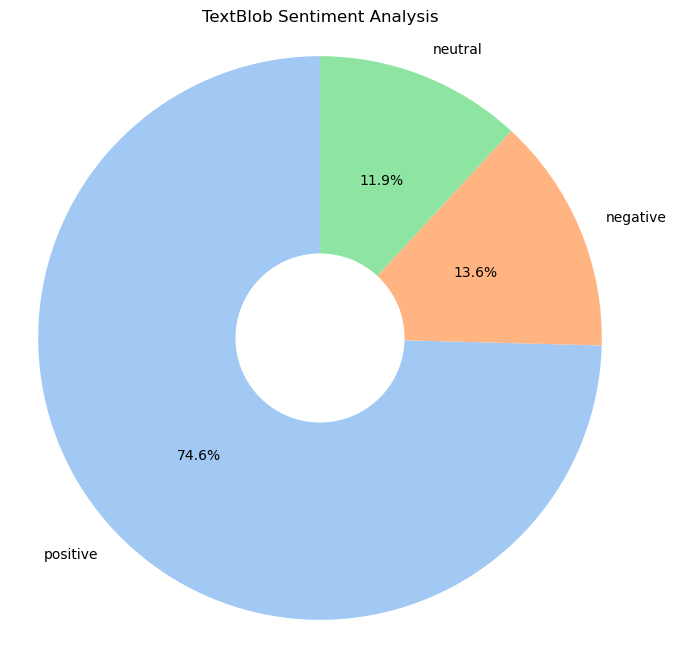

In [25]:
labels_textblob = ["positive", "negative", "neutral"]
sizes_textblob = [goodBlob, badBlob, neutralBlob]

# Creates a donut chart using Seaborn
plt.figure(figsize=(8, 8))
plt.pie(sizes_textblob, labels=labels_textblob, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel", 3), wedgeprops=dict(width=0.7))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('TextBlob Sentiment Analysis')

# plot
plt.show()

#### NaiveBayes Donut Chart

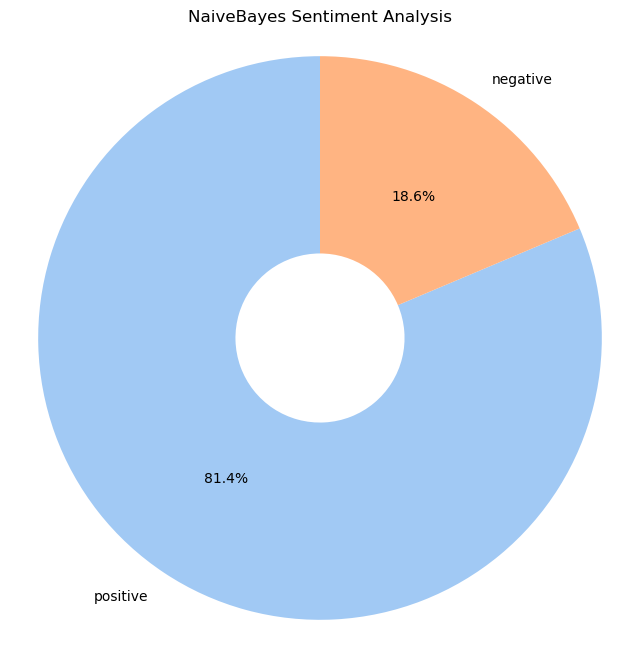

In [30]:
labels_textblob = ["positive", "negative"] #took out neutrals becuase naivebayes does not give neutrals
sizes_textblob = [goodBayes, badBayes]

# Creates donut chart using Seaborn
plt.figure(figsize=(8, 8))
plt.pie(sizes_textblob, labels=labels_textblob, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel", 3), wedgeprops=dict(width=0.7))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('NaiveBayes Sentiment Analysis')

# plot
plt.show()


#### Overall, both textblob and naivebayes show mostly positive reviews of the tacos in Salt Lake city. Whereas textblob includes neutral values, naivebayes instead splits the neutrals into good and bad reviews. So naivebayes believes there are more good and bad reviews, but textblob is likely more accurate since some reviews are bound to be neutral.

#### Word Cloud Image

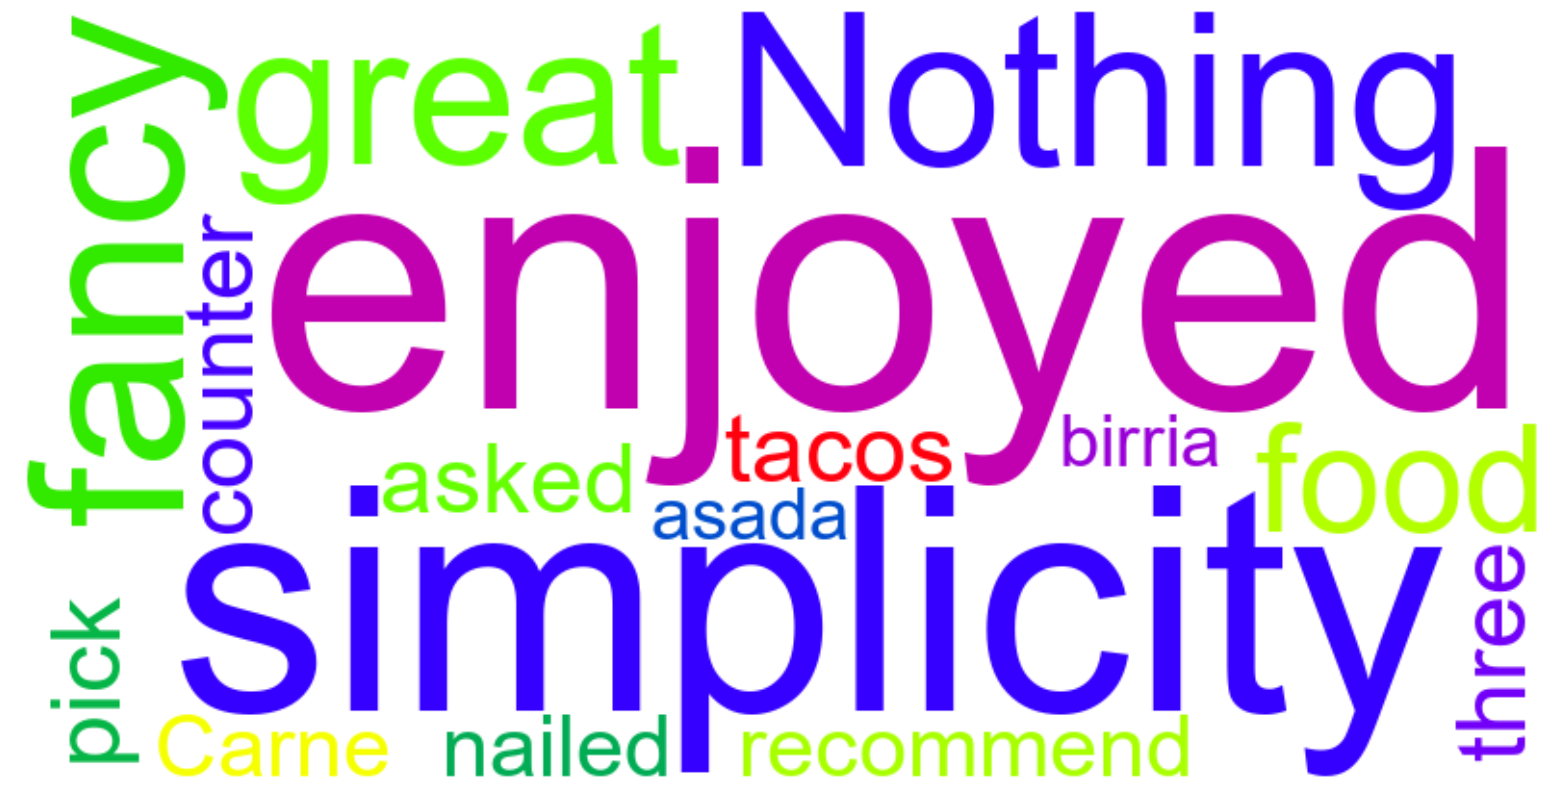

In [50]:
# joins review texts into a single string
text = ' '.join(processed_review)

word_freq = Counter(text.split())
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='prism', max_words=20, font_path='arial')
wordcloud.generate_from_frequencies(word_freq)

# Plot
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### I learned several things from this analysis including what Birria tacos are (they look really good) and that most people enjoy the tacos in the salt lake city area. I also learned that reviews most commonly brought up the words "Enjoyed" and "Simplicity", which is interesting because I didn't think the simplicity of the food would come up nearly as much.